Dataset Loaded Successfully!
First 5 rows:
      battery_id host_material_id battery_formula framework_formula  \
0   mp-754407_Li        mp-756094       Li1-2FeS2              FeS2   
1  mp-1045431_Zn       mp-1390701     Zn0-0.5CoS2              CoS2   
2     mp-7564_Rb          mp-7564   Rb0-0.5Nb3Te4            Nb3Te4   
3  mp-1041415_Zn       mp-1047798   Zn0-0.5CuMoO4            CuMoO4   
4  mp-1043107_Zn       mp-1043472   Zn0-1NiMoP2O9          NiMoP2O9   

     chemsys formula_anonymous working_ion  nelements  sum_Atomic_Number_WI  \
0       Fe-S               AB2          Li          2                     3   
1       Co-S               AB2          Zn          2                    30   
2      Nb-Te              A3B4          Rb          2                    37   
3    Cu-Mo-O              ABC4          Zn          3                    30   
4  Mo-Ni-O-P            ABC2D9          Zn          4                    30   

   sum_ionic_radius_WI  sum_Pauling_Electronegativity_W

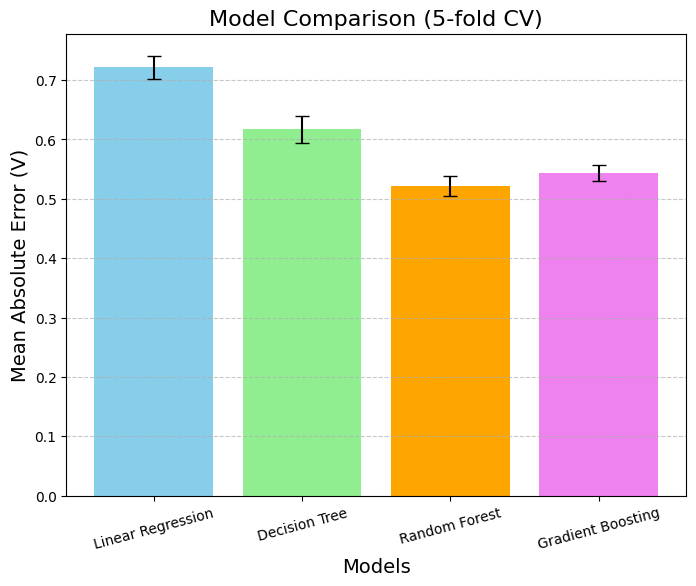

Best model selected: Random Forest

Training the best model: Random Forest ...
Final Test MAE: 0.509 V
Learning curve not available for the selected model.
For demonstration, training a Gradient Boosting Regressor for learning curve analysis...


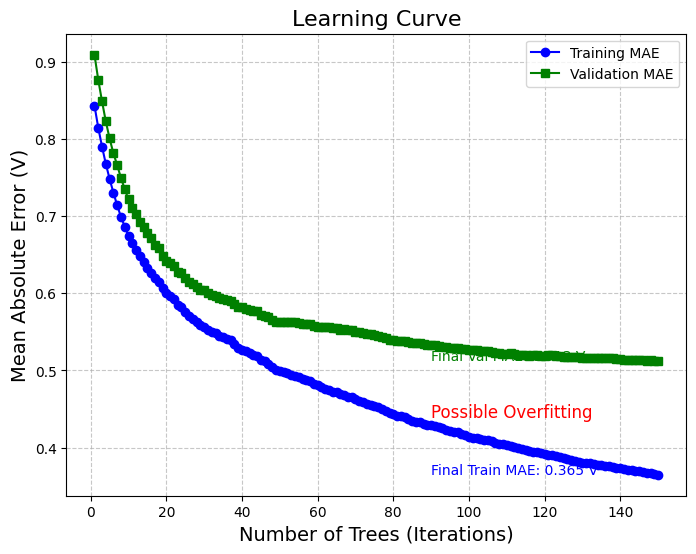

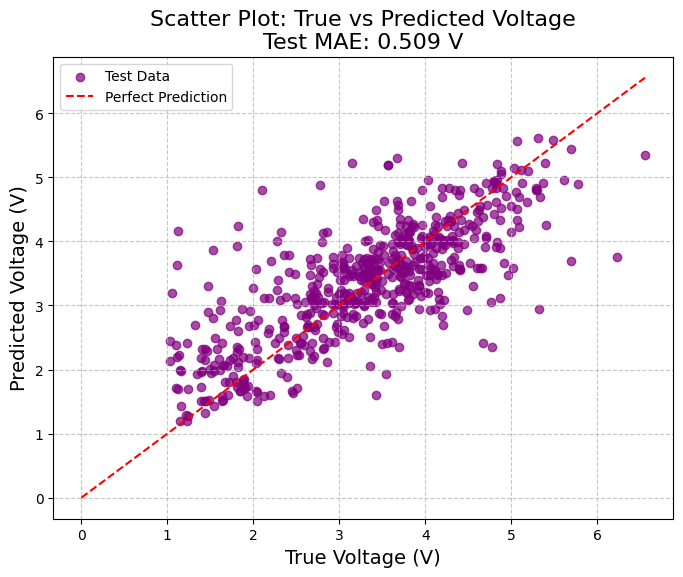

<ipython-input-1-301b4ef07a57>:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")


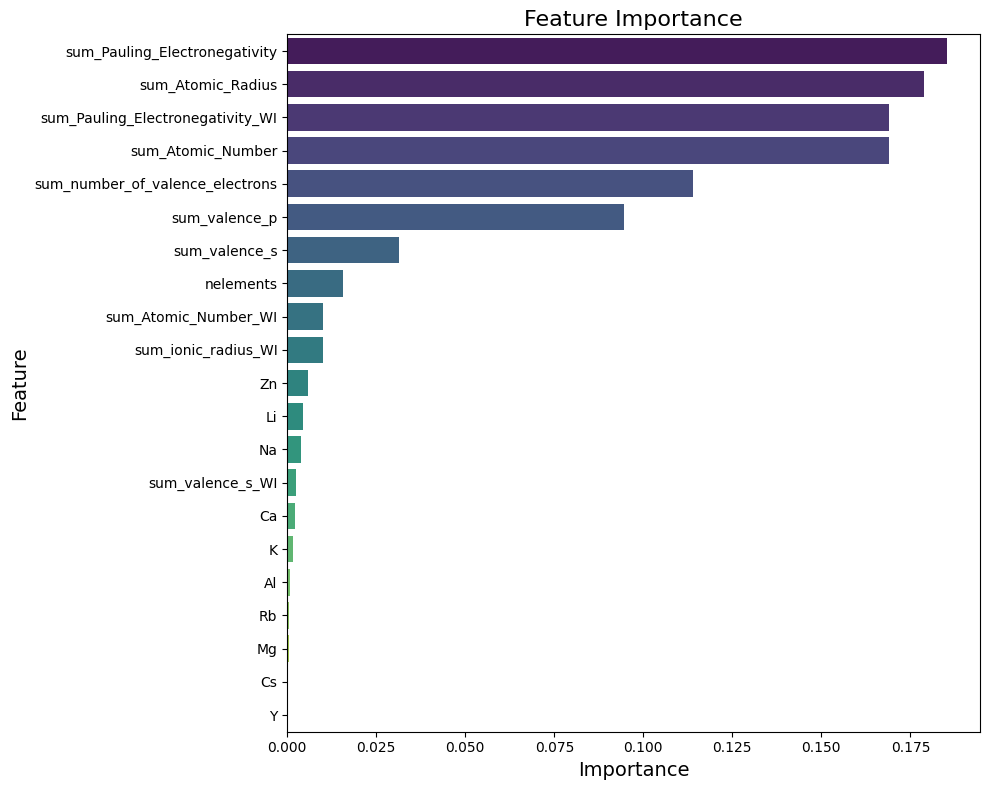

Model saved as best_model.pkl


In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

class BatteryML:
    def __init__(self, github_url):
        """
        Initialize the pipeline with the GitHub URL for the dataset.
        """
        self.github_url = github_url
        self.filename = "Battery_data.xlsx"
        self.df = None
        self.x = self.y = None
        self.x_train = self.x_val = self.x_test = None
        self.y_train = self.y_val = self.y_test = None
        self.selected_model = None
        self.selected_model_name = None
        self.train_errors = []  # For learning curve: training errors over iterations
        self.val_errors = []    # For learning curve: validation errors over iterations
        self.cv_results = {}    # CV mean MAE for each model
        self.cv_std = {}        # CV standard deviation for each model

    def download_data(self):
        """
        Download the dataset from GitHub if it doesn't exist locally.
        """
        if not os.path.exists(self.filename):
            print("Downloading dataset from GitHub...")
            os.system(f"wget {self.github_url} -O {self.filename}")
        else:
            print("Dataset already exists. Skipping download.")

    def load_data(self):
        """
        Load the dataset from the Excel file.
        """
        self.df = pd.read_excel(self.filename)
        print("Dataset Loaded Successfully!")
        print("First 5 rows:")
        print(self.df.head())

    def preprocess_data(self):
        """
        Preprocess the dataset by dropping unnecessary columns and performing
        one-hot encoding on the categorical 'working_ion' column.
        """
        df1 = self.df.drop(['battery_id', 'host_material_id', 'battery_formula',
                            'framework_formula', 'chemsys', 'formula_anonymous'], axis=1)
        one_hot = pd.get_dummies(df1['working_ion'])
        df1_encoded = pd.concat([df1, one_hot], axis=1)
        df2 = df1_encoded.drop(['working_ion'], axis=1)
        if df2.isna().sum().sum() > 0:
            print("Missing values detected; dropping rows with NANs.")
            df2 = df2.dropna()
        self.x = df2.drop(['average_voltage'], axis=1)
        self.y = df2['average_voltage']
        print(f"Preprocessing complete. Features shape: {self.x.shape}, Target shape: {self.y.shape}")

    def split_data(self):
        """
        Split the dataset into training (70%), validation (15%), and test (15%) sets.
        """
        x_train, x_temp, y_train, y_temp = train_test_split(self.x, self.y, test_size=0.3, random_state=42)
        x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test
        self.x_val, self.y_val = x_val, y_val
        print(f"Data split into:\n - Training: {x_train.shape}\n - Test: {x_test.shape}\n - Validation: {x_val.shape}")

    def model_comparison(self):
        """
        Compare several ML models using 5-fold cross-validation on the training set.
        A bar plot is produced showing the mean MAE (with error bars).
        The model with the lowest mean MAE is selected.
        """
        print("\nComparing models using cross-validation:")
        models = {
            "Linear Regression": LinearRegression(),
            "Decision Tree": DecisionTreeRegressor(),
            "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
            "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
        }
        for name, model in models.items():
            scores = -cross_val_score(model, self.x_train, self.y_train, scoring="neg_mean_absolute_error", cv=5)
            self.cv_results[name] = scores.mean()
            self.cv_std[name] = scores.std()
            print(f"{name}: MAE = {scores.mean():.3f} V ± {scores.std():.3f}")

        plt.figure(figsize=(8,6))
        names = list(self.cv_results.keys())
        means = [self.cv_results[name] for name in names]
        stds = [self.cv_std[name] for name in names]
        plt.bar(names, means, yerr=stds, capsize=5, color=['skyblue', 'lightgreen', 'orange', 'violet'])
        plt.ylabel("Mean Absolute Error (V)", fontsize=14)
        plt.xlabel("Models", fontsize=14)
        plt.title("Model Comparison (5-fold CV)", fontsize=16)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=15)
        plt.show()

        # Select the best model based on CV MAE
        self.selected_model_name = min(self.cv_results, key=self.cv_results.get)
        print(f"Best model selected: {self.selected_model_name}")
        if self.selected_model_name == "Linear Regression":
            self.selected_model = LinearRegression()
        elif self.selected_model_name == "Decision Tree":
            self.selected_model = DecisionTreeRegressor()
        elif self.selected_model_name == "Random Forest":
            self.selected_model = RandomForestRegressor(n_estimators=100, random_state=42)
        elif self.selected_model_name == "Gradient Boosting":
            self.selected_model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)

    def train_best_model(self):
        """
        Train the selected best model on the training set.
        If the selected model supports staged predictions, its learning curve is plotted.
        Otherwise, for demonstration purposes, a Gradient Boosting Regressor is trained
        to show a learning curve.
        """
        print(f"\nTraining the best model: {self.selected_model_name} ...")
        self.selected_model.fit(self.x_train, self.y_train)
        y_pred_test = self.selected_model.predict(self.x_test)
        test_mae = mean_absolute_error(self.y_test, y_pred_test)
        print(f"Final Test MAE: {test_mae:.3f} V")

        if hasattr(self.selected_model, "staged_predict"):
            self.train_errors = []
            self.val_errors = []
            for y_train_pred, y_val_pred in zip(self.selected_model.staged_predict(self.x_train),
                                                  self.selected_model.staged_predict(self.x_val)):
                self.train_errors.append(mean_absolute_error(self.y_train, y_train_pred))
                self.val_errors.append(mean_absolute_error(self.y_val, y_val_pred))
            self.plot_learning_curve(self.train_errors, self.val_errors)
        else:
            print("Learning curve not available for the selected model.")
            print("For demonstration, training a Gradient Boosting Regressor for learning curve analysis...")
            gbr_model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)
            gbr_model.fit(self.x_train, self.y_train)
            train_errs = []
            val_errs = []
            for y_train_pred, y_val_pred in zip(gbr_model.staged_predict(self.x_train),
                                                  gbr_model.staged_predict(self.x_val)):
                train_errs.append(mean_absolute_error(self.y_train, y_train_pred))
                val_errs.append(mean_absolute_error(self.y_val, y_val_pred))
            self.plot_learning_curve(train_errs, val_errs)

    def plot_learning_curve(self, train_errors, val_errors):
        """
        Plot a detailed learning curve showing training and validation MAE over iterations.
        Annotate final errors and indicate any potential overfitting.
        """
        iterations = range(1, len(train_errors) + 1)
        plt.figure(figsize=(8,6))
        plt.plot(iterations, train_errors, label="Training MAE", color="blue", marker="o")
        plt.plot(iterations, val_errors, label="Validation MAE", color="green", marker="s")
        plt.xlabel("Number of Trees (Iterations)", fontsize=14)
        plt.ylabel("Mean Absolute Error (V)", fontsize=14)
        plt.title("Learning Curve", fontsize=16)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        final_train = train_errors[-1]
        final_val = val_errors[-1]
        plt.text(iterations[-1]*0.6, final_train, f"Final Train MAE: {final_train:.3f} V", color="blue")
        plt.text(iterations[-1]*0.6, final_val, f"Final Val MAE: {final_val:.3f} V", color="green")
        if final_train + 0.1 < final_val:
            plt.text(iterations[-1]*0.6, (final_train+final_val)/2, "Possible Overfitting", color="red", fontsize=12)
        plt.show()

    def plot_scatter(self):
        """
        Plot a scatter plot of true vs. predicted values on the test set.
        The plot includes a diagonal line indicating perfect predictions and annotates the test MAE.
        """
        y_pred = self.selected_model.predict(self.x_test)
        test_mae = mean_absolute_error(self.y_test, y_pred)
        plt.figure(figsize=(8,6))
        plt.scatter(self.y_test, y_pred, color='purple', alpha=0.7, label="Test Data", marker='o')
        max_val = max(np.max(self.y_test), np.max(y_pred))
        plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label="Perfect Prediction")
        plt.xlabel("True Voltage (V)", fontsize=14)
        plt.ylabel("Predicted Voltage (V)", fontsize=14)
        plt.title(f"Scatter Plot: True vs Predicted Voltage\nTest MAE: {test_mae:.3f} V", fontsize=16)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    def feature_importance(self):
        """
        Plot feature importances if provided by the model.
        """
        if hasattr(self.selected_model, "feature_importances_"):
            importance_df = pd.DataFrame({
                'Feature': self.x_train.columns,
                'Importance': self.selected_model.feature_importances_
            }).sort_values(by='Importance', ascending=False)
            plt.figure(figsize=(10,8))
            sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
            plt.xlabel("Importance", fontsize=14)
            plt.ylabel("Feature", fontsize=14)
            plt.title("Feature Importance", fontsize=16)
            plt.tight_layout()
            plt.show()
        else:
            print("The selected model does not provide feature importances.")

    def save_model(self, filename="best_model.pkl"):
        """
        Save the selected best model to a file.
        """
        joblib.dump(self.selected_model, filename)
        print(f"Model saved as {filename}")

# === Running the Pipeline ===
github_file_url = "https://raw.githubusercontent.com/Souvik-ml/ML-Workshop/main/Battery_data.xlsx"
battery_ml = BatteryML(github_file_url)
battery_ml.download_data()
battery_ml.load_data()
battery_ml.preprocess_data()
battery_ml.split_data()
battery_ml.model_comparison()
battery_ml.train_best_model()
battery_ml.plot_scatter()
battery_ml.feature_importance()
battery_ml.save_model()

### Feature Generate using pymatgen

In [6]:
!pip install pymatgen

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 33.9 MB/s eta 0:00:00


### General features

In [7]:
from pymatgen.core import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import numpy as np

class StructureFeatureExtractor:
    def __init__(self, cif_file):
        """
        Initialize the extractor with the path to a CIF file.
        The structure is loaded using Pymatgen's Structure.from_file.
        """
        self.cif_file = cif_file
        self.structure = Structure.from_file(cif_file)
        self.features = {}  # Dictionary to store all extracted features

    def extract_lattice_features(self):
        """
        Extract lattice parameters and related features.

        Features extracted:
          - a, b, c: Lattice vector lengths (in Å)
          - alpha, beta, gamma: Lattice angles (in degrees)
          - volume: Unit cell volume (in Å^3)
          - density: Density of the structure (g/cm^3)
        """
        lattice = self.structure.lattice
        self.features["a (Å)"] = lattice.a
        self.features["b (Å)"] = lattice.b
        self.features["c (Å)"] = lattice.c
        self.features["alpha (°)"] = lattice.alpha
        self.features["beta (°)"] = lattice.beta
        self.features["gamma (°)"] = lattice.gamma
        self.features["Volume (Å³)"] = lattice.volume
        self.features["Density (g/cm³)"] = self.structure.density
        return self.features

    def extract_symmetry_features(self):
        """
        Extract symmetry-related features using SpacegroupAnalyzer.

        Features extracted:
          - space_group: Space group symbol (e.g., "P2₁/c")
          - space_group_number: International number for the space group
          - crystal_system: Crystal system (e.g., "monoclinic")
        """
        sga = SpacegroupAnalyzer(self.structure)
        self.features["Space Group"] = sga.get_space_group_symbol()
        self.features["Space Group Number"] = sga.get_space_group_number()
        self.features["Crystal System"] = sga.get_crystal_system()
        return self.features

    def extract_coordination_features(self, cutoff=3.0):
        """
        Extract coordination features by counting neighbors within a cutoff distance.

        For each atomic site, the number of neighbors within the specified cutoff (default 3 Å)
        is calculated. From these, the following features are computed:
          - average_coordination: Average coordination number across all sites
          - min_coordination: Minimum coordination number
          - max_coordination: Maximum coordination number
        """
        coordination_numbers = []
        for site in self.structure:
            # get_neighbors returns a list of Neighbor objects within the cutoff distance
            neighbors = self.structure.get_neighbors(site, cutoff)
            coordination_numbers.append(len(neighbors))

        self.features["Average Coordination"] = np.mean(coordination_numbers)
        self.features["Min Coordination"] = np.min(coordination_numbers)
        self.features["Max Coordination"] = np.max(coordination_numbers)
        return self.features

    def extract_all_features(self):
        """
        Extract all structural features and return them as a dictionary.
        """
        self.extract_lattice_features()
        self.extract_symmetry_features()
        self.extract_coordination_features()
        return self.features

# Example usage:
if __name__ == "__main__":
    # Replace "example.cif" with the path to your CIF file.
    cif_path = "CaTiO3.cif"

    extractor = StructureFeatureExtractor(cif_path)
    features = extractor.extract_all_features()

    print("Extracted Structural Features:")
    for key, value in features.items():
        print(f"{key}: {value}")


Extracted Structural Features:
a (Å): 5.46279649
b (Å): 7.63635962
c (Å): 5.37204886
alpha (°): 90.0
beta (°): 90.0
gamma (°): 90.0
Volume (Å³): 224.09973769300066
Density (g/cm³): 4.02925941391082 g cm^-3
Space Group: Pnma
Space Group Number: 62
Crystal System: orthorhombic
Average Coordination: 10.4
Min Coordination: 6
Max Coordination: 13


In [9]:
!pip install nglview

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 46.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install ase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 23.3 MB/s eta 0:00:00


### Bonding Connectivity

Atomic Species Present: {'Ti', 'Ca', 'O'}


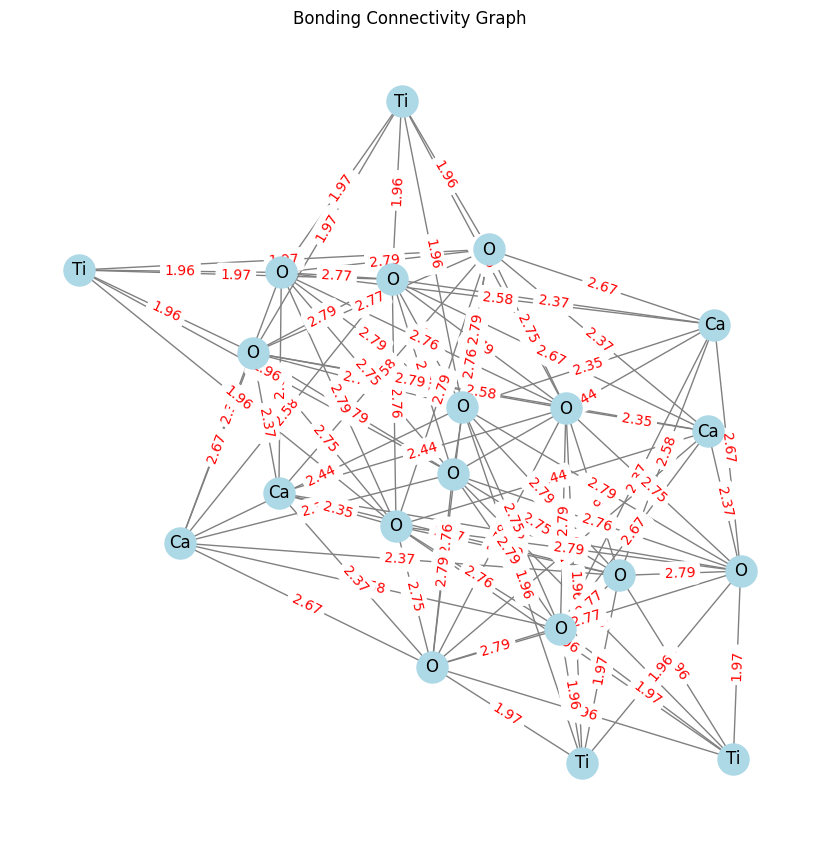

In [1]:
# Make sure you have installed the following libraries:
# !pip install pymatgen nglview networkx matplotlib

from pymatgen.core import Structure
import networkx as nx
import matplotlib.pyplot as plt
import nglview as nv

class StructureVisualizer:
    def __init__(self, cif_file):
        """
        Initialize the visualizer with the path to a CIF file.
        The structure is loaded using pymatgen's Structure.from_file.
        """
        self.cif_file = cif_file
        self.structure = Structure.from_file(cif_file)

    def print_atomic_species(self):
        """
        Print the unique atomic species present in the structure.
        """
        species = {site.specie.symbol for site in self.structure}
        print("Atomic Species Present:", species)

    def visualize_structure(self):
        """
        Visualize the structure interactively using nglview.
        (This works best in a Jupyter/Colab environment.)
        """
        view = nv.show_pymatgen(self.structure)
        # You can display the view directly in a Jupyter Notebook:
        return view

    def generate_connectivity_graph(self, cutoff=3.0):
        """
        Generate a connectivity graph from the structure.

        Parameters:
            cutoff (float): Maximum distance (in Å) to consider two atoms bonded.

        Returns:
            A networkx Graph where:
              - Nodes represent atoms and carry an attribute 'element' (the atom's symbol).
              - Edges represent bonds between atoms (neighbors within the cutoff).
        """
        G = nx.Graph()
        # Add nodes: each node is an atom indexed by its order in the structure
        for i, site in enumerate(self.structure):
            G.add_node(i, element=site.specie.symbol, coords=site.coords)
        # Add edges: loop over each site and add an edge to its neighbors
        for i, site in enumerate(self.structure):
            neighbors = self.structure.get_neighbors(site, cutoff)
            for neighbor in neighbors:
                j = neighbor.index  # neighbor's index in the structure
                # Avoid duplicate edges (i < j ensures each bond is added only once)
                if i < j:
                    G.add_edge(i, j, distance=neighbor.nn_distance)
        return G

    def plot_bonding_graph(self, cutoff=3.0):
        """
        Plot the bonding connectivity graph using networkx and matplotlib.
        Nodes are labeled with the atomic species and edges are annotated with the bond length.
        """
        G = self.generate_connectivity_graph(cutoff)
        # Use a spring layout for visualization (set a seed for reproducibility)
        pos = nx.spring_layout(G, seed=42)
        labels = {i: G.nodes[i]['element'] for i in G.nodes}
        plt.figure(figsize=(8,8))
        nx.draw(G, pos, with_labels=True, labels=labels, node_size=500,
                node_color='lightblue', font_size=12, edge_color='gray')
        # Draw edge labels (bond distances)
        edge_labels = {(u, v): f"{d['distance']:.2f}" for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
        plt.title("Bonding Connectivity Graph")
        plt.show()

# ------------------------------
# Example usage in a Jupyter/Colab Notebook:
# ------------------------------
if __name__ == "__main__":
    # Replace 'example.cif' with the path to your CIF file.
    cif_path = "CaTiO3.cif"

    visualizer = StructureVisualizer(cif_path)

    # Print the atomic species present
    visualizer.print_atomic_species()

    # Visualize the crystal structure interactively (in a notebook cell, simply display the view)
    view = visualizer.visualize_structure()
    view  # In Jupyter/Colab, this will render the interactive viewer.

    # Plot the bonding connectivity graph (using a 3.0 Å cutoff by default)
    visualizer.plot_bonding_graph(cutoff=3.0)


# Covert it into tabular format

In [2]:
import pandas as pd
from pymatgen.core import Structure

def connectivity_to_dataframe(structure, cutoff=3.0):
    """
    Generate a pandas DataFrame containing bonding connectivity information.

    Each row represents a bond between two atoms, where:
      - Atom1_Index and Atom2_Index: indices in the structure
      - Atom1_Element and Atom2_Element: element symbols
      - Bond_Distance: the distance between the two atoms

    Parameters:
        structure (Structure): A pymatgen Structure object loaded from a CIF file.
        cutoff (float): Distance cutoff in Å to consider atoms as bonded.

    Returns:
        pd.DataFrame: DataFrame with bonding connectivity data.
    """
    bonds = []
    for i, site in enumerate(structure):
        neighbors = structure.get_neighbors(site, cutoff)
        for neighbor in neighbors:
            j = neighbor.index  # Neighbor's index in the structure
            # To avoid duplicate entries, record only when i < j
            if i < j:
                bonds.append({
                    "Atom1_Index": i,
                    "Atom1_Element": site.specie.symbol,
                    "Atom2_Index": j,
                    "Atom2_Element": structure[j].specie.symbol,
                    "Bond_Distance (Å)": neighbor.nn_distance
                })
    return pd.DataFrame(bonds)

# Example usage:
if __name__ == "__main__":
    # Replace "example.cif" with the path to your CIF file.
    cif_file = "CaTiO3.cif"
    structure = Structure.from_file(cif_file)

    connectivity_df = connectivity_to_dataframe(structure, cutoff=3.0)
    print("Bonding Connectivity DataFrame:")
    print(connectivity_df)


Bonding Connectivity DataFrame:
     Atom1_Index Atom1_Element  Atom2_Index Atom2_Element  Bond_Distance (Å)
0              0            Ca           14             O           2.374113
1              0            Ca            9             O           2.374113
2              0            Ca           17             O           2.346101
3              0            Ca           13             O           2.583408
4              0            Ca           15             O           2.670761
..           ...           ...          ...           ...                ...
99            14             O           17             O           2.748299
100           15             O           16             O           2.748299
101           15             O           17             O           2.791225
102           15             O           19             O           2.787932
103           15             O           18             O           2.758655

[104 rows x 5 columns]
